In [1]:
import os
import sys
# sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')
sys.path.append('C:/Users/USER/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

os.chdir(current_dir_path + '\\ultils')
# os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *

# os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

from Version3.tdamapper.core import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive

c:\Users\USER\Desktop\TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [157]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他',

    # 兩個欄位只有兩個觀察值不同
    '肇因研判大類別名稱-主要',
    # '肇因研判大類別名稱-個別',
]
# select_lst = dataA1.columns
def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

dist_dfA2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] != '未紀錄']
dist_dfA1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] != '未紀錄']
car_A2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] == '車的狀態']
car_A1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] == '車的狀態']

car_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
car_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)

car_A2 = car_A2[car_A2['肇因研判大類別名稱-主要'] != '非駕駛者']
car_A1 = car_A1[car_A1['肇因研判大類別名稱-主要'] != '非駕駛者']
car_A2 = car_A2[car_A2['肇因研判大類別名稱-主要'] != '無(非車輛駕駛人因素)']
car_A1 = car_A1[car_A1['肇因研判大類別名稱-主要'] != '無(非車輛駕駛人因素)']
# 刪掉原因為類似於他提供不了更多資訊，但會使Mapper更加分散
car_A2 = car_A2[car_A2['肇因研判大類別名稱-主要'] != '無(車輛駕駛者因素)']
car_A1 = car_A1[car_A1['肇因研判大類別名稱-主要'] != '無(車輛駕駛者因素)']

car_A2 = car_A2[car_A2['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']
car_A1 = car_A1[car_A1['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']

car_A2 = car_A2[car_A2['車輛撞擊部位大類別名稱-最初'] != '未紀錄']
car_A1 = car_A1[car_A1['車輛撞擊部位大類別名稱-最初'] != '未紀錄']


C:\Users\USER\AppData\Local\Temp\ipykernel_33992\3605155225.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_33992\3605155225.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



篩選掉未紀錄資料以及分類人的狀態以及車的狀態

In [158]:
from sklearn.utils import resample

sampling_ratio = 0.33  # 下採樣比例

# 計算 A1 和 A2 原始數據量比例
A1_total = len(car_A1)
A2_total = len(car_A2)
total_ratio = A1_total / A2_total  # 保留 A1/A2 的比例

# 定義函數，按月份進行下採樣
def downsample_by_month_simple(A1, A2, sampling_ratio, total_ratio):
    A1_downsampled = pd.DataFrame()
    A2_downsampled = pd.DataFrame()

    months = sorted(set(A1['發生月份']).intersection(A2['發生月份']))  # 確保月份匹配

    for month in months:
        # 提取該月份的資料
        A1_month = A1[A1['發生月份'] == month]
        A2_month = A2[A2['發生月份'] == month]

        # 計算該月份目標數量
        A1_target = int(len(A1_month) * sampling_ratio)
        A2_target = int(A1_target / total_ratio)
        print(A1_target)
        print(A2_target)

        # 下採樣
        A1_sampled = resample(A1_month, replace=False, n_samples=A1_target, random_state=42)
        A2_sampled = resample(A2_month, replace=False, n_samples=A2_target, random_state=42)

        # 合併到最終結果
        A1_downsampled = pd.concat([A1_downsampled, A1_sampled])
        A2_downsampled = pd.concat([A2_downsampled, A2_sampled])

    return A1_downsampled.reset_index(drop=True), A2_downsampled.reset_index(drop=True)

# 下採樣
downsampled_A1, downsampled_A2 = downsample_by_month_simple(car_A1, car_A2, sampling_ratio, total_ratio)
# Concat
rbind_data = pd.concat([downsampled_A1, downsampled_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)

44
10080
45
10309
40
9163
35
8018
36
8247
39
8934
47
10767
43
9851
40
9163
47
10767


In [159]:
bins_age = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels_age = ['未滿15歲', '15~24', '25~34', '35~44', '45~54', '55~64', '65~74', '75+']

rbind_data['當事者事故發生時年齡'] = pd.cut(rbind_data['當事者事故發生時年齡'], bins=bins_age, labels=labels_age, right=False)

rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].cat.add_categories('未知')
rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].fillna('未知')

bins_speed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, float('inf')]
labels_speed = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '110+']

rbind_data['速限-第1當事者'] = pd.cut(rbind_data['速限-第1當事者'], bins=bins_speed, labels=labels_speed, right=False)

# assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
# mapper_numpy = data_to_map.to_numpy()

dummy_data: (95715, 146)


          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.122         2.95%                      2.95%
1              0.120         2.89%                      5.84%
2              0.089         2.15%                      7.99%
3              0.076         1.85%                      9.84%
4              0.075         1.82%                     11.65%
5              0.072         1.73%                     13.38%
6              0.066         1.60%                     14.98%


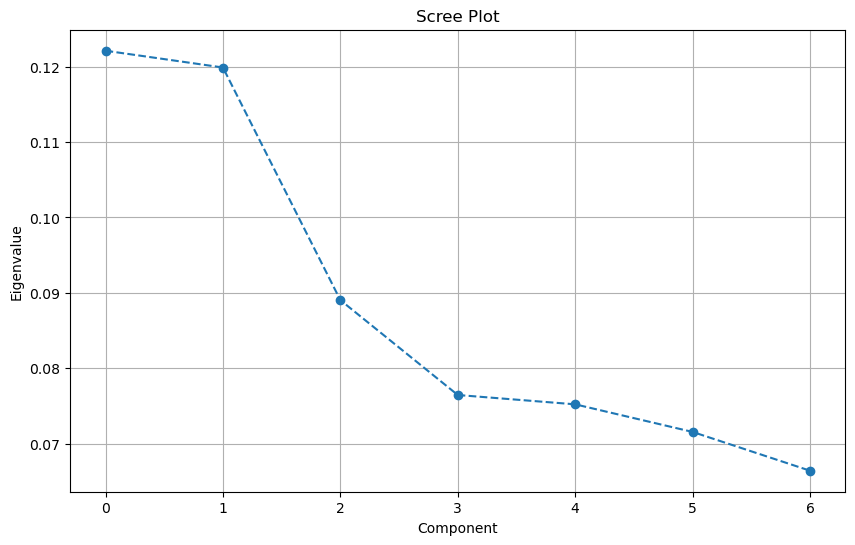

In [29]:
import prince

mca = prince.MCA(
    one_hot=False,
    n_components=7,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
)

mca.fit(data_to_map)
lens = mca.transform(data_to_map)

print(mca.eigenvalues_summary)

eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.cm as cm

col_coordinate = mca.column_coordinates(data_to_map)

plt.rcParams['font.family'] = 'Microsoft YaHei'
col_coordinate['dummy_index'] = range(len(col_coordinate))  # 為每個欄位分配索引

# Normalize the 'dummy_index' for mapping to colormap
norm = plt.Normalize(vmin=col_coordinate['dummy_index'].min(), vmax=col_coordinate['dummy_index'].max())
cmap = cm.viridis  # 選擇漸層色盤，例如 viridis, plasma, inferno 等

plt.figure(figsize=(20, 12))

plt.gca().set_facecolor('#b55a1d')

# 繪製散點圖，顏色根據 dummy_index 映射
scatter = plt.scatter(
    col_coordinate[0],  # X coordinate
    col_coordinate[1],  # Y coordinate
    c=col_coordinate['dummy_index'],  # 使用索引作為顏色映射
    cmap=cmap,
    alpha=0.7
)

# Adding labels with colors matching the scatter plot
offset = 0.15
for i, label in enumerate(col_coordinate.index):
    plt.text(
        col_coordinate.iloc[i, 0],  # X coordinate
        col_coordinate.iloc[i, 1] + offset,  # Y coordinate
        str(label),  # 假設 label 包含中文
        fontsize=10,
        ha='center', 
        va='center',
        color=cmap(norm(col_coordinate.iloc[i]['dummy_index'])),  # 文字顏色與點顏色一致
        # rotation=30
    )

# Add colorbar
# cbar = plt.colorbar(scatter)
# cbar.set_label("Field Index (Gradient)", fontsize=12)

# Axes lines and grid
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
# plt.title("MCA", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.grid(True)

plt.show()

In [109]:
Overlap = [0.52]
Interval = [9]

In [ ]:
# detailed_results = []

In [110]:
# for overlap in range(1, 6):
for overlap in Overlap:
    silhouette_for_intervals = []

    # for interval in range(2, 11):
    for interval in Interval:
        try:
            print(f'overlap: {overlap}, interval: {interval}')

            mapper_algo = MapperAlgorithm(
                cover=CubicalCover(
                    n_intervals=interval,
                    overlap_frac=overlap / 10
                ),
                clustering=FailSafeClustering(
                    AgglomerativeClustering(
                        n_clusters=2,
                        linkage='ward'
                    )
                ),
                n_jobs=10
            )

            mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
            silhouette_for_intervals.append(mapper_info[1])

            result = {
                "overlap": overlap,
                "interval": interval,
                "silhouette": mapper_info[1],
                "mapper_info": mapper_info
            }

            detailed_results.append(result)

            filename = f"C:/Users/USER/Desktop/TrafficTDApython/Version3/Component7Car/results_o{overlap}i{interval}.pkl"
            # filename = f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o{overlap}i{interval}.pkl"

            with open(filename, 'wb') as file:
                pickle.dump(result, file)

            print(f"Results saved to {filename}")

        except Exception as e:
            print(f"Error for overlap={overlap}, interval={interval}: {e}")

            continue

overlap: 0.52, interval: 9


Processing Clusters: 100%|██████████| 2845/2845 [00:01<00:00, 1968.67it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component7Car/results_o0.52i9.pkl


In [111]:
detailed_results_df = pd.DataFrame(detailed_results)
# detailed_results_df.to_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/full_grid_halfdata.csv", index=False)

# output_file = '/Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component6Car/full_grid.pkl'
output_file = 'C:/Users/USER/Desktop/TrafficTDApython/Version3/Component7Car/full_grid.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(detailed_results_df, f)

In [8]:
output_file = 'C:/Users/USER/Desktop/TrafficTDApython/Version3/Component8Car/full_grid.pkl'

with open(output_file, 'rb') as f:
    detailed_results_df = pickle.load(f)

In [36]:
import seaborn as sns
from matplotlib.font_manager import FontProperties
# myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
# sns.set(style="whitegrid", font=myfont.get_name())
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

from matplotlib.cm import get_cmap
from plots import *

In [ ]:
choose = '速限-第1當事者'

unique_categories = rbind_data[choose].dropna().unique()
# 統一顏色
color_palette = get_cmap("tab20", len(unique_categories))
color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[6][0], 
                            rbind_data, detailed_results_df)
mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
mapper_plotter.extract_data()
mapper_plotter.map_colors(choose, color_mapping_fixed, size=25) # 篩選資料
mapper_plotter.plot(choose, unique_categories, color_palette, avg=False, 
                    set_label=True, size=1000000)

In [107]:
detailed_results_df

,overlap,interval,silhouette,mapper_info
0,1.00,2,468.708220,"((0, 1, 5, 2, 4, 7, 8, 12, 10, 20, 36, 15, 16,..."
1,1.00,6,23.648120,"((1, 30, 3, 40, 322, 821, 4, 6, 9, 11, 46, 12,..."
2,1.00,10,10.471097,"((0, 2, 5, 240, 7, 10, 53, 11, 13, 1635, 8, 16..."
3,3.00,2,942.321802,"((0, 1, 4, 34, 36, 2, 13, 5, 7, 8, 10, 35, 3, ..."
4,3.00,6,91.980485,"((1, 169, 342, 2, 115, 394, 759, 834, 4, 30, 7..."
5,3.00,10,30.500965,"((1, 589, 1020, 2663, 2, 4, 56, 247, 392, 819,..."
6,5.00,2,5032.131053,"((1, 4, 6, 8, 10, 0, 11, 9, 2, 5, 7, 3), 5032...."
7,5.00,6,362.170922,"((0, 15, 23, 38, 53, 77, 84, 100, 184, 198, 20..."
8,5.00,10,78.905306,"((0, 29, 468, 749, 780, 1096, 2, 48, 177, 348,..."
9,2.00,7,37.329773,"((0, 29, 800, 2, 277, 921, 1354, 4, 589, 6, 9,..."


In [ ]:
choose = '當事者行動狀態大類別名稱'
# choose = '死亡'

unique_categories = rbind_data[choose].dropna().unique()
unique_categories.sort()

# 統一顏色
color_palette = get_cmap("tab20", len(unique_categories))
color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[39][0], 
                            rbind_data, detailed_results_df)
mplot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
mapper_plotter.extract_data()
mapper_plotter.map_colors(choose, color_mapping_fixed, size=30) # 篩選資料
mapper_plotter.plot(choose, unique_categories, color_palette, avg=False, 
                    set_label=False, size=1000)

In [129]:
detailed_results_df.shape[0]

61

In [ ]:
# choose = 'Cluster'
choose = '死亡'

unique_categories = rbind_data[choose].dropna().unique()
unique_categories.sort()

color_palette = get_cmap("tab20", len(unique_categories))
color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[39][0], 
                            rbind_data, detailed_results_df)
mplot = mapper_plotter.create_mapper_plot(choose, average_encoded_label, avg=True)
mapper_plotter.extract_data()
mapper_plotter.map_colors(choose, color_mapping_fixed, size=30) # 篩選資料
mapper_plotter.plot(choose, unique_categories, color_palette, avg=True, 
                    set_label=True, size=100000)

In [ ]:
# choose = 'Cluster'
choose = '死亡'

unique_categories = rbind_data[choose].dropna().unique()
unique_categories.sort()

for index in range(detailed_results_df.shape[0]):
# for index in range(51,52):
    # 統一顏色
    color_palette = get_cmap("tab20", len(unique_categories))
    color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[index][0], 
                                rbind_data, detailed_results_df)
    mplot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, color_mapping_fixed, size=30) # 篩選資料
    mapper_plotter.plot(choose, unique_categories, color_palette, avg=False, 
                        set_label=False, size=1000,
                        save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/Mapper/Car/o{detailed_results_df['overlap'].iloc[index]}_i{detailed_results_df['interval'].iloc[index]}.png")

In [133]:
dataA1.columns

Index(['發生年度', '發生月份', '發生日期', '發生時間', '事故類別名稱', '處理單位名稱警局層', '發生地點', '天候名稱',
       '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱',
       '事故位置大類別名稱', '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
       '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '肇因研判大類別名稱-主要', '肇因研判子類別名稱-主要', '死亡受傷人數', '當事者順位',
       '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態大類別名稱', '當事者行動狀態子類別名稱',
       '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '車輛撞擊部位子類別名稱-其他',
       '肇因研判大類別名稱-個別', '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃', '經度', '緯度'],
      dtype='object')

In [148]:
lst = ['當事者行動狀態子類別名稱',
       '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '車輛撞擊部位子類別名稱-其他',
       '肇因研判大類別名稱-個別', '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃']

In [ ]:
for choose in lst:
    unique_categories = rbind_data[choose].dropna().unique()
    # 統一顏色
    color_palette = get_cmap("tab20", len(unique_categories))
    color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[39][0], 
                                rbind_data, detailed_results_df)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, color_mapping_fixed, size=25) # 篩選資料
    mapper_plotter.plot(choose, unique_categories, color_palette, avg=False, 
                        set_label=True, size=1000000, # 限制點的大小
                        save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Car/o2_i11_{choose}.png")

In [161]:
from kmodes.kmodes import KModes

# data_for_kmode = rbind_data.drop(['死亡', '受傷', 'color_for_plot'], axis=1)
data_for_kmode = rbind_data.drop(['死亡', '受傷'], axis=1)

print(data_for_kmode.columns)

Index(['天候名稱', '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '路面狀況-路面鋪裝名稱',
       '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
       '號誌-號誌種類名稱', '號誌-號誌動作名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '肇事逃逸類別名稱-是否肇逃', '道路型態大類別名稱',
       '事故位置大類別名稱', '車道劃分設施-分向設施大類別名稱', '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種',
       '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-主要'],
      dtype='object')


In [48]:
cost = []
all_results = {}
K = range(1, 10)

for k in K:
    
    km = KModes(
    n_clusters=k, 
    init='Huang',
    verbose=1,
    random_state=42,
    n_jobs=5
    )

    labels = km.fit_predict(data_for_kmode)
    cost.append(km.cost_)
    all_results[k] = {
        'cost': km.cost_,
        'labels': labels,
        'centroids': km.cluster_centroids_
    }

optimal_k = K[cost.index(min(cost))]
optimal_result = all_results[optimal_k]

Best run was number 1
Best run was number 4
Best run was number 8
Best run was number 2
Best run was number 9
Best run was number 9
Best run was number 3
Best run was number 4
Best run was number 7


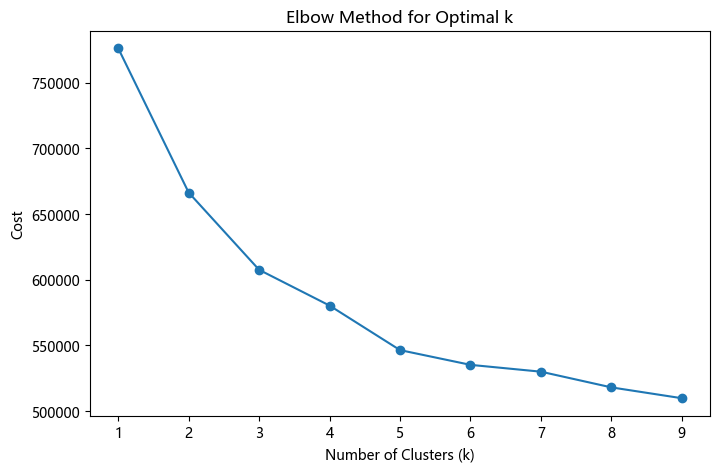

In [49]:
plt.figure(figsize=(8, 5))
plt.plot(K, cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

In [163]:
rbind_data['Cluster'] = all_results[3]['labels']

# DBSCAN 標籤

In [ ]:
choose = '天候名稱'
# choose = '年齡_int'

unique_categories = rbind_data[choose].dropna().unique()
# 統一顏色
color_palette = get_cmap("tab20", len(unique_categories))
color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[39][0], 
                            rbind_data, detailed_results_df)
mplot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
full_info = mapper_plotter.extract_data()
mapper_plotter.map_colors(choose, color_mapping_fixed, size=30) # 篩選資料
mapper_plotter.plot(choose, unique_categories, color_palette, avg=False, 
                    set_label=True, size=100000)

In [ ]:
# give me a dbscan using the info
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.01, min_samples=5)
dbscan.fit(full_info[['x', 'y']])
full_info['label'] = dbscan.labels_

# plot using info, color by Cluster
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=full_info,
    x='x',
    y='y',
    hue='label',
    palette="tab10"
)
plt.show()